* **[Phase 1 - Data Collection and Visualization](#phase1)**
   - [Imports & Installations](#import)
   - [Data Loading](#step01)   
   - [Data Parsing & Cleaning](#step02)  
   - [Data Flattening](#step03)  
   - [Exporting Data to Excel](#step04)  

* **[Phase 2 - Data Storage and Processing Pipeline](#phase2)**
   - [creating database and importing data](#step11)
   - [Database Queries and Explorations](#step12)
   - [Review Initial Insights (EDA)](#step13)
   - [Perform Advanced Feature Engineering](#step14)
   - [Image Data Preprocessing and Visual Feature Extraction](#step15)
   - [Comprehensive Data Preprocessing](#step16)
   - [Blurry Image Detection and Labeling](#step17)
   - [Blurry Image Statics](#step21)
   - [General Overview of the Database](#step18)
   - [Creating an AI Pipeline](#step19)
   - [CI/CD  Implementation](#step20)
* **[Phase 3 - Final Conclusions and Model Development](#phase3)**


<a id='phase1'></a>
## **Phase 1 - Data Collection and Visualization**

<a id='import'></a>
### **Imports & Installations**

In [1]:
# !pip install kagglehub
# !pip install openpyxl

In [2]:
import xml.etree.ElementTree as ET
import kagglehub
import os
import pandas as pd

<a id='step01'></a>
### **Data Loading**

In [3]:
path_to_dataset = "content"
"""
If the dataset is not downloaded to your local machine you can use the following
commented command:
"""
# path_to_dataset = kagglehub.dataset_download("andrewmvd/car-plate-detection")

annotation_folder = os.path.join(path_to_dataset, "annotations")
image_folder = os.path.join(path_to_dataset, "images")



<a id='step02'></a>
### **Data Parsing & Cleaning**

In [4]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    size = {
        'width': root.find('size/width').text,
        'height': root.find('size/height').text
    }
        
    objects = [{
            'bndbox': {
                'xmin': object.find('bndbox/xmin').text,
                'ymin': object.find('bndbox/ymin').text,
                'xmax': object.find('bndbox/xmax').text,
                'ymax': object.find('bndbox/ymax').text,
            }
        } for object in root.findall('object')]
           
    extracted_info = {
        'folder': root.find('folder').text,
        'filename': root.find('filename').text,
        'size': size,
        'objects': objects
    }
    
    return extracted_info 


<a id='step03'></a>
### **Data Flattening**

In [8]:
records = []
for file in os.listdir(annotation_folder):
    if file.endswith(".xml"):
        data = parse_xml(os.path.join(annotation_folder, file))
        for obj in data["objects"]:
            row = {
                "filename": data["filename"],
                "folder": data["folder"],
                "width": int(data["size"]["width"]),
                "height": int(data["size"]["height"]),
                "xmin": int(obj["bndbox"]["xmin"]),
                "ymin": int(obj["bndbox"]["ymin"]),
                "xmax": int(obj["bndbox"]["xmax"]),
                "ymax": int(obj["bndbox"]["ymax"])
            }
            records.append(row)


NameError: name 'annotation_folder' is not defined

<a id='step04'></a>
### **Exporting Data to Excel**

In [7]:
df = pd.DataFrame(records)
excel_path = os.path.join('content', 'car_plate_annotations.xlsx')
df.to_excel(excel_path, index=False)

print(f"Data exported successfully to {excel_path}")

NameError: name 'records' is not defined

<a id='phase2'></a>
## **Phase 2 - Data Storage and Processing Pipeline**

<a id='step11'></a>
### **creating database and importing data**

In [6]:
import sqlite3
import pandas as pd





os.makedirs('database', exist_ok=True)




df = pd.read_excel(excel_path)

df['image_path'] = df['filename'].apply(lambda x: os.path.join('content', 'images', x))


db_path = os.path.join('database', 'dataset.db')


conn = sqlite3.connect(db_path)

conn.execute('''
CREATE TABLE IF NOT EXISTS image_annotations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    filename TEXT NOT NULL,
    folder TEXT NOT NULL,
    width INTEGER NOT NULL,
    height INTEGER NOT NULL,
    xmin INTEGER NOT NULL,
    ymin INTEGER NOT NULL,
    xmax INTEGER NOT NULL,
    ymax INTEGER NOT NULL,
    image_path TEXT NOT NULL,
    UNIQUE(filename) 
);
''')


df.to_sql(
    name='image_annotations',
    con=conn,
    if_exists='replace',
    index=False,
    dtype={
        'filename': 'TEXT',
        'folder': 'TEXT',
        'width': 'INTEGER',
        'height': 'INTEGER',
        'xmin': 'INTEGER',
        'ymin': 'INTEGER',
        'xmax': 'INTEGER',
        'ymax': 'INTEGER',
        'image_path': 'TEXT'
    }
)
conn.commit()
conn.close()


print("✅ Initial database created.")


NameError: name 'excel_path' is not defined

<a id='step12'></a>
### **Database Queries and Explorations**

This script performs exploratory analysis on `image_annotations` table from the local SQLite database (`dataset.db`). Below are the queries and their purposes:


1. General Data Overview
Displays the **first 20 records** from the `image_annotations` table to provide a quick glimpse of the dataset.

2. Top 15 Biggest Plates by Area
Calculates bounding box area and lists the **top 15 plates** with the **largest bounding box areas**.

3. Top 10 Largest Images by Dimensions
Ranks images based on their overall resolution (`width * height`) and lists the **10 largest images**.

4. Plates with Unusual Aspect Ratios
Identifies the **top 10 plates** where the **aspect ratio (width/height)** is **less than 0.5**, indicating potentially distorted or anomalous annotations.

In [8]:
import sqlite3
import pandas as pd


conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Query 1: General data overview (first 20 records)
print("\n=== GENERAL DATA OVERVIEW (first 20 records) ===")
cursor.execute("SELECT * FROM image_annotations LIMIT 20")
general_data = cursor.fetchall()
for row in general_data:
    print(row)

# Query 2: Top 15 biggest plates by area
print("\n=== TOP 15 BIGGEST PLATES BY AREA ===")
cursor.execute("""
    SELECT filename, (xmax-xmin)*(ymax-ymin) as area 
    FROM image_annotations 
    ORDER BY area DESC 
    LIMIT 15
""")
top_plates = cursor.fetchall()
for plate in top_plates:
    print(f"File: {plate[0]}, Area: {plate[1]} pixels")

# Query 3: Top 10 largest pictures overall (by image dimensions)
print("\n=== TOP 10 LARGEST PICTURES (BY DIMENSIONS) ===")
cursor.execute("""
    SELECT filename, width, height 
    FROM image_annotations 
    ORDER BY (width * height) DESC 
    LIMIT 10
""")
big_pics = cursor.fetchall()
for pic in big_pics:
    print(f"File: {pic[0]}, Size: {pic[1]}x{pic[2]} pixels")


# Query 4: Plates with small aspect ratios (potential anomalies)
print("\n=== PLATES WITH UNUSUAL ASPECT RATIOS (<0.5) ===")
cursor.execute("""
    SELECT filename, 
           (xmax-xmin)/(ymax-ymin) as aspect_ratio
    FROM image_annotations
    WHERE (xmax-xmin)/(ymax-ymin) < 0.5
    ORDER BY ABS(1.0 - (xmax-xmin)/(ymax-ymin)) DESC LIMIT 10
""")
weird_plates = cursor.fetchall()
for plate in weird_plates:
    print(f"File: {plate[0]}, Aspect Ratio: {plate[1]:.2f}")

conn.close()


=== GENERAL DATA OVERVIEW (first 20 records) ===
('Cars0.png', 'images', 500, 268, 226, 125, 419, 173, 'content\\images\\Cars0.png')
('Cars1.png', 'images', 400, 248, 134, 128, 262, 160, 'content\\images\\Cars1.png')
('Cars10.png', 'images', 400, 225, 140, 5, 303, 148, 'content\\images\\Cars10.png')
('Cars100.png', 'images', 400, 267, 175, 114, 214, 131, 'content\\images\\Cars100.png')
('Cars101.png', 'images', 400, 300, 167, 202, 240, 220, 'content\\images\\Cars101.png')
('Cars102.png', 'images', 350, 263, 66, 147, 322, 199, 'content\\images\\Cars102.png')
('Cars103.png', 'images', 400, 196, 230, 129, 248, 134, 'content\\images\\Cars103.png')
('Cars103.png', 'images', 400, 196, 189, 116, 202, 121, 'content\\images\\Cars103.png')
('Cars104.png', 'images', 500, 374, 195, 266, 244, 282, 'content\\images\\Cars104.png')
('Cars105.png', 'images', 400, 240, 152, 147, 206, 159, 'content\\images\\Cars105.png')
('Cars106.png', 'images', 400, 247, 138, 79, 177, 92, 'content\\images\\Cars106.png

<a id='step13'></a>
### **Review Initial Insights (EDA)**

- **Plot 1:**  
  Many images fall around the 400 × 400 pixel size range.

- **Plot 2:**  
  License plate lengths range from 0 to 100 pixels, and widths range from 0 to 50 pixels.

- **Plot 3:**  
  The area of most plates is around 1000 pixels² (showing an exponential-like distribution).

- **Plot 4:**  
  Most images have exactly one detected plate (about %86.6).


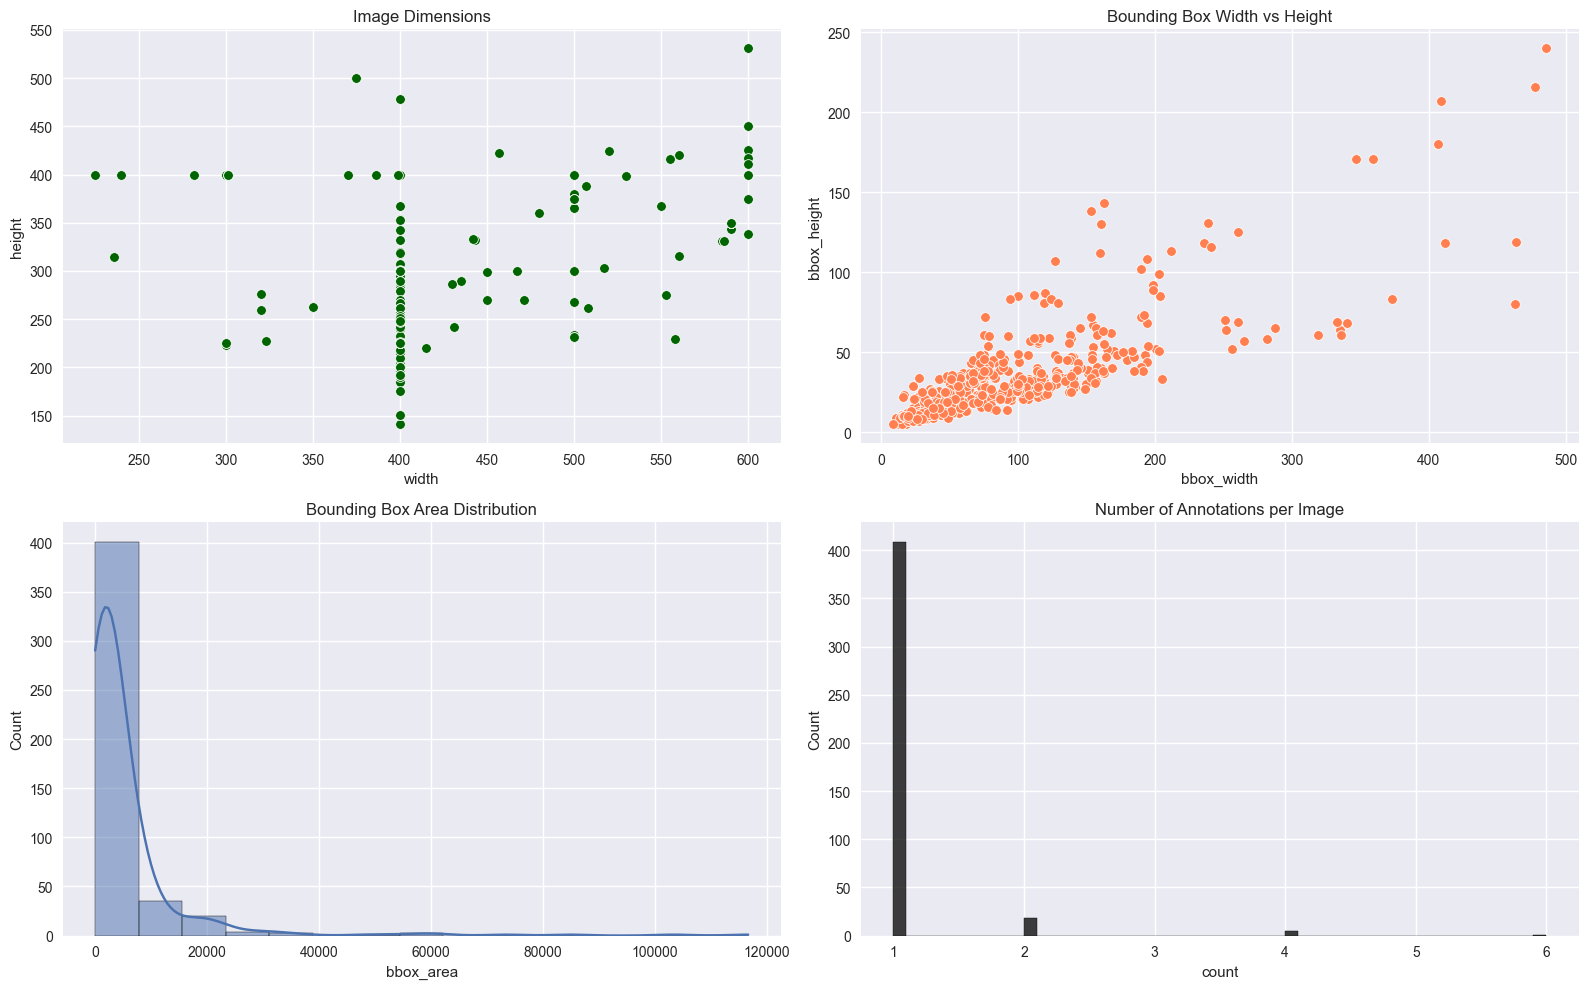

In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')


conn = sqlite3.connect(db_path)

df = pd.read_sql_query("SELECT * FROM image_annotations", conn)

conn.close()

df['bbox_width'] = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']
df['bbox_area'] = df['bbox_width'] * df['bbox_height']

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='width', y='height', data=df, color='darkgreen')
plt.title("Image Dimensions")

plt.subplot(2, 2, 2)
sns.scatterplot(x='bbox_width', y='bbox_height', data=df, color='coral')
plt.title("Bounding Box Width vs Height")

plt.subplot(2, 2, 3)
sns.histplot(df['bbox_area'], bins=15, kde=True)
plt.title("Bounding Box Area Distribution")

plt.subplot(2, 2, 4)
annotation_counts = df['filename'].value_counts()
sns.histplot(annotation_counts, bins=50, color='black')
plt.title("Number of Annotations per Image")

plt.tight_layout()
plt.show()


<a id='step14'></a>
### **Perform Advanced Feature Engineering**

we engineered several visual and spatial features to aid OCR-based modeling. These features help normalize input, understand plate positioning, and assess visual scale and alignment across the dataset.

We created the following advanced features:

- **`bbox_width` and `bbox_height`**: The pixel width and height of each annotated plate, calculated as `xmax - xmin` and `ymax - ymin`. These are important for detecting elongated or squished plates.

- **`bbox_area`**: The area (in pixels) of the plate region, helping detect abnormal sizes that may affect OCR accuracy.

- **`aspect_ratio`**: Computed as `bbox_width / bbox_height`, indicating the geometric proportions of the plate. This is crucial since license plates typically follow consistent formats (e.g., 4:1 width-to-height ratio).

- **`area_fraction`**: The proportion of the image covered by the plate (`bbox_area / (width * height)`). Helps understand scale and whether plates are zoomed-in or distant.

- **`center_x_norm` and `center_y_norm`**: The normalized center coordinates of each bounding box, giving insight into spatial distribution and plate alignment (values between 0 and 1).

- **`margin_left`, `margin_right`, `margin_top`, `margin_bottom`**: Distance (in pixels) from the plate edges to the image borders. Useful for analyzing whether plates are centered or edge-aligned.

These features collectively provide rich information about the visual and spatial properties of plates. They will support the **OCR preprocessing pipeline** in the next phase by enabling:

- Selection of consistent plate crops for input into OCR models.
- Filtering or augmenting images with small, poorly framed, or off-centered plates.
- Data quality checks for outlier bounding boxes before modeling.



In [10]:
import sqlite3
import pandas as pd

# Basic derived features
df['bbox_width']  = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']
df['bbox_area']   = df['bbox_width'] * df['bbox_height']

# Aspect ratio of each bounding box
df['aspect_ratio'] = df['bbox_width'] / df['bbox_height']

# Fraction of image covered by the plate
df['area_fraction'] = df['bbox_area'] / (df['width'] * df['height'])

# Normalized center coordinates (useful for spatial models)
df['center_x_norm'] = ((df['xmin'] + df['xmax']) / 2) / df['width']
df['center_y_norm'] = ((df['ymin'] + df['ymax']) / 2) / df['height']

# Edge margins (distance from plate to each image border)
df['margin_left']   = df['xmin']
df['margin_top']    = df['ymin']
df['margin_right']  = df['width']  - df['xmax']
df['margin_bottom'] = df['height'] - df['ymax']

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

conn.execute('''
CREATE TABLE IF NOT EXISTS engineered_plate_features (
    id INTEGER PRIMARY KEY AUTOINCREMENT,  -- Auto-incremented primary key
    filename TEXT NOT NULL,
    bbox_width REAL NOT NULL,
    bbox_height REAL NOT NULL,
    bbox_area REAL NOT NULL,
    aspect_ratio REAL NOT NULL,
    area_fraction REAL NOT NULL,
    center_x_norm REAL NOT NULL,
    center_y_norm REAL NOT NULL,
    margin_left INTEGER NOT NULL,
    margin_top INTEGER NOT NULL,
    margin_right INTEGER NOT NULL,
    margin_bottom INTEGER NOT NULL,
    FOREIGN KEY(filename) REFERENCES image_annotations(filename)  -- Foreign key to image_annotations table
);
''')

df[['filename', 'bbox_width', 'bbox_height', 'bbox_area', 'aspect_ratio', 
    'area_fraction', 'center_x_norm', 'center_y_norm', 'margin_left', 
    'margin_top', 'margin_right', 'margin_bottom']].to_sql(
    name='engineered_plate_features',
    con=conn,
    if_exists='replace',  
    index=False
)

conn.commit()
conn.close()


<a id='step15'></a>
### **Image Data Preprocessing and Visual Feature Extraction**

To prepare the plate regions for OCR and modeling, we performed the following:

- **Cropping**: Each license plate was cropped using its bounding box.
- **Resizing**: Standardized to 128×32 pixels to ensure consistent model input.
- **Normalization**: Pixel values scaled to the [0.0, 1.0] range.
- **Grayscale conversion**: Reduced noise and simplified OCR feature space.

These steps ensure that all plate images are uniform and suitable for OCR or classification in downstream modeling tasks.

In [11]:
import os
import cv2

# Load data from the database
conn = sqlite3.connect(db_path)
query = """
SELECT 
    p.filename, p.image_path, 
    p.xmin, p.ymin, p.xmax, p.ymax,
    f.bbox_width, f.bbox_height
FROM image_annotations AS p
JOIN engineered_plate_features AS f
  ON p.filename = f.filename
"""
df = pd.read_sql_query(query, conn)
conn.close()

output_folder = 'content/plates'
os.makedirs(output_folder, exist_ok=True)

mean_w = int(df['bbox_width'].mean())
mean_h = int(df['bbox_height'].mean())
output_size = (mean_w, mean_h)

df['preprocessed_plate'] = None
df['preprocessed_folder'] = output_folder

for idx, row in df.iterrows():
    img_path = row['image_path']
    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Could not read image: {img_path}")
        continue

    # Crop and preprocess
    x0, y0, x1, y1 = row[['xmin','ymin','xmax','ymax']]
    cropped = image[y0:y1, x0:x1]
    resized = cv2.resize(cropped, output_size)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    norm = (gray.astype('float32') / 255.0 * 255).astype('uint8')

    # Save the image
    plate_name = f'plate_{idx:04d}.png'
    save_path = os.path.join(output_folder, plate_name)
    cv2.imwrite(save_path, norm)

    # Store file info in DataFrame
    df.at[idx, 'preprocessed_plate'] = plate_name

print("✅ Plates saved and names assigned.")


✅ Plates saved and names assigned.


In [12]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

try:
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN preprocessed_plate TEXT;")
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN preprocessed_folder TEXT;")
except sqlite3.OperationalError:
    pass

conn.commit()

for _, row in df.iterrows():
    cursor.execute("""
        UPDATE engineered_plate_features
        SET preprocessed_plate = ?, preprocessed_folder = ?
        WHERE filename = ?
    """, (row['preprocessed_plate'], row['preprocessed_folder'], row['filename']))

conn.commit()
conn.close()

print("✅ Database table 'engineered_plate_features' updated with new file info.")

✅ Database table 'engineered_plate_features' updated with new file info.


<a id='step16'></a>
### **Comprehensive Data Preprocessing**

To ensure clean and model-ready data, we conducted the following preprocessing steps:

- **Removal of No-Plate Entries**: A number of records in the dataset were found to contain no valid license plate annotations, indicated by all bounding box coordinates being zero. These entries were removed from the dataset before feature engineering and database insertion to prevent invalid computations and ensure data integrity.

- **Feature Normalization**: Key numeric features (bounding box sizes, aspect ratio, spatial location) were normalized to [0, 1] using Min-Max scaling. This prevents scale dominance in distance-based models.

- **Redundant Feature Removal**: Features with high pairwise correlation  were dropped after statistical analysis to avoid multicollinearity.

- **Blurry Image Labeling**: All preprocessed plate images were analyzed for sharpness using Laplacian variance. Plates with low blur scores were marked as blurry (`is_blurry = 1`) and stored in the database. This allows for selective filtering of low-quality samples during OCR training or evaluation, without discarding them entirely.


This step ensures the dataset is consistent, scaled, and relevant for downstream modeling tasks like OCR.

**Removal of No-Plate Entries**

In [13]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Delete rows where there is no plate (bounding box size is zero)
cursor.execute("""
    DELETE FROM image_annotations
    WHERE xmin = 0 AND ymin = 0 AND xmax = 0 AND ymax = 0;
""")

conn.commit()
conn.close()

**Feature Normalization**

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Load raw + feature data with a JOIN
conn = sqlite3.connect(db_path)
query = """
SELECT 
    p.filename, p.image_path, 
    p.xmin, p.ymin, p.xmax, p.ymax,
    f.bbox_width, f.bbox_height,
    f.bbox_area, f.aspect_ratio, f.area_fraction,
    f.center_x_norm, f.center_y_norm
FROM image_annotations AS p
JOIN engineered_plate_features AS f
  ON p.filename = f.filename
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Scale the numeric columns
scaler = MinMaxScaler()
cols_to_scale = ['bbox_width', 'bbox_height', 'bbox_area', 'aspect_ratio', 
                 'area_fraction', 'center_x_norm', 'center_y_norm']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


**Redundant Feature Removal**

We computed the pairwise correlations among our 11 numerical features.  

In [15]:
import numpy as np

conn = sqlite3.connect(db_path)
query = """
SELECT 
    p.filename, p.image_path, 
    p.xmin, p.ymin, p.xmax, p.ymax,
    f.bbox_width, f.bbox_height,
    f.bbox_area, f.aspect_ratio, f.area_fraction,
    f.center_x_norm, f.center_y_norm, f.margin_top,
    f.margin_left, margin_right, margin_bottom
FROM image_annotations AS p
JOIN engineered_plate_features AS f
  ON p.filename = f.filename
"""
df = pd.read_sql_query(query, conn)
conn.close()

cols = ['bbox_width','bbox_height','bbox_area',
        'aspect_ratio','area_fraction',
        'center_x_norm','center_y_norm',
        'margin_left','margin_top','margin_right','margin_bottom']

corr = df[cols].corr().abs()

corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)
print(corr_pairs.head(10))


bbox_area      area_fraction    0.947417
center_x_norm  margin_right     0.905302
bbox_height    area_fraction    0.904572
               bbox_area        0.897184
center_x_norm  margin_left      0.895958
bbox_width     bbox_area        0.834511
               bbox_height      0.820283
               area_fraction    0.817168
center_y_norm  margin_bottom    0.809705
               margin_top       0.720838
dtype: float64


After computing the correlation matrix, several features were identified as highly correlated (ρ > 0.90). To simplify the feature space and reduce multicollinearity:

- `bbox_area` was dropped in favor of `area_fraction`, which is normalized.

- `margin_left`, `margin_right`, and `margin_bottom` were removed due to strong correlation with `center_x_norm` and `center_y_norm`.

- `bbox_width` and `bbox_height` were retained for interpretability despite moderate correlation with `bbox_area`.

This resulted in a compact, non-redundant set of features used for modeling.

In [16]:
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM engineered_plate_features", conn)

to_drop = ['bbox_area', 'margin_left', 'margin_right', 'margin_bottom']
df_reduced = df.drop(columns=to_drop, errors='ignore')

df_reduced.to_sql(
    name='engineered_plate_features',
    con=conn,
    if_exists='replace',
    index=False
)

conn.commit()
conn.close()

print("✅ Reduced features saved to 'engineered_plate_features' in the database.")


✅ Reduced features saved to 'engineered_plate_features' in the database.


<a id='step17'></a>
### **Blurry Image Detection and Labeling**

To ensure image quality, each preprocessed license plate image was analyzed for blurriness using the variance of the Laplacian method — a common edge-based technique for measuring sharpness.

**Detection Method**:
- The Laplacian of each grayscale plate image was computed.
- The variance of the Laplacian (`blur_score`) was used as a sharpness indicator.
- A threshold of 100.0 was used:
  - Images with a blur score below this were labeled as **blurry** (`is_blurry = 1`).
  - Others were labeled as **clear** (`is_blurry = 0`).

**Database Integration**:
- Two new columns were added to the `engineered_plate_features` table:
  - `blur_score` — a numeric sharpness score.
  - `is_blurry` — a binary label for blur (0 = clear, 1 = blurry).
- This labeling enables downstream filtering of poor-quality data, training robust models, or evaluating OCR performance under image degradation.

In [17]:
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    var_lap = lap.var()
    return var_lap < threshold, var_lap

def estimate_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.std(gray)  # higher std = noisier image

results = []

plate_dir = os.path.join('content','plates' )
for fname in os.listdir(plate_dir):
    path = os.path.join(plate_dir, fname)
    img = cv2.imread(path)

    blurry, score = is_blurry(img)
    results.append({'preprocessed_plate': fname, 'blur_score': score, 'is_blurry': blurry})

df_blur = pd.DataFrame(results)
print(df_blur.sort_values(by='blur_score').head(10))

    preprocessed_plate  blur_score  is_blurry
8       plate_0008.png    9.108026       True
9       plate_0009.png    9.108026       True
317     plate_0317.png   11.210800       True
318     plate_0318.png   11.210800       True
83      plate_0083.png   15.511619       True
80      plate_0080.png   15.511619       True
82      plate_0082.png   15.511619       True
81      plate_0081.png   15.511619       True
561     plate_0561.png   17.510107       True
91      plate_0091.png   18.192420       True


In [18]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

try:
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN is_blurry INTEGER;")
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN blur_score REAL;")
except sqlite3.OperationalError:
    pass
    
for _, row in df_blur.iterrows():
    cursor.execute("""
        UPDATE engineered_plate_features
        SET is_blurry = ?, blur_score = ?
        WHERE preprocessed_plate = ?
    """, (row['is_blurry'], row['blur_score'], row['preprocessed_plate']))

conn.commit()
conn.close()

print("✅ Blurry plate status updated in database.")


✅ Blurry plate status updated in database.


<a id='step21'></a>
### **Blurry Image Statics**

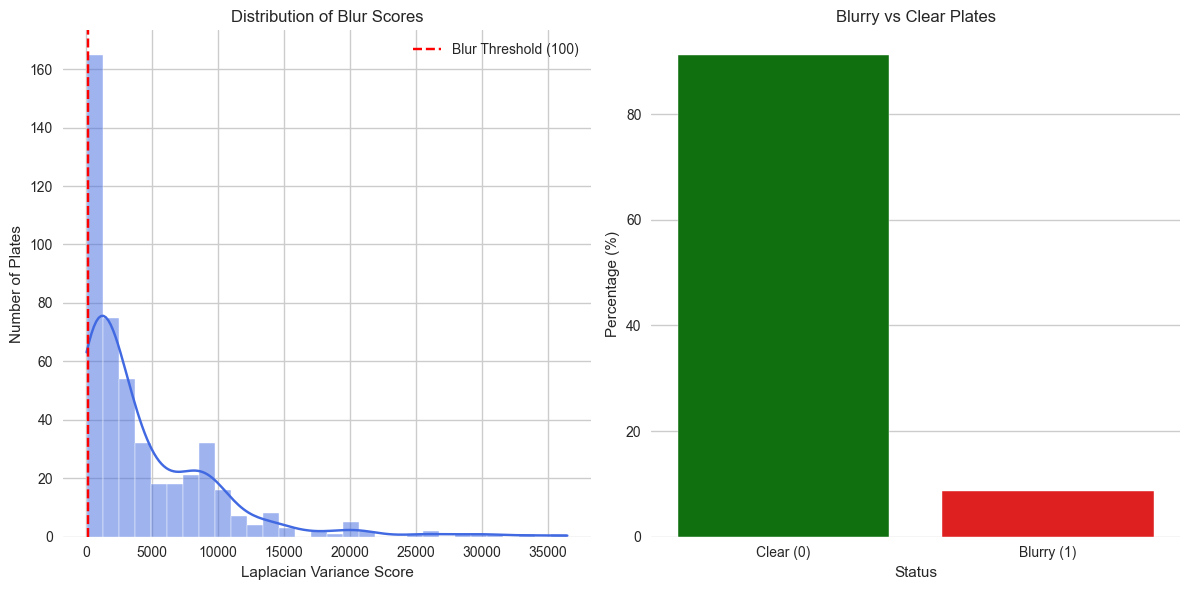


Blur Score Statistics:
- Mean: 4391.7
- Median: 2294.7
- Std Dev: 5507.1

Blurry Plates: 41 (8.7%)


In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect(db_path)
df = pd.read_sql_query("""
    SELECT blur_score, is_blurry 
    FROM engineered_plate_features
    WHERE blur_score IS NOT NULL
""", conn)
conn.close()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.subplot(1, 2, 1)
sns.histplot(df['blur_score'], bins=30, kde=True, color='royalblue')
plt.axvline(x=100, color='red', linestyle='--', label='Blur Threshold (100)')
plt.title('Distribution of Blur Scores')
plt.xlabel('Laplacian Variance Score')
plt.ylabel('Number of Plates')
plt.legend()

plt.subplot(1, 2, 2)
blur_stats = df['is_blurry'].value_counts(normalize=True).mul(100).reset_index()
blur_stats.columns = ['blur_status', 'percentage']

sns.barplot(x='blur_status', y='percentage', hue='blur_status', 
            data=blur_stats, palette=['green', 'red'], 
            legend=False, order=[0, 1])
plt.title('Blurry vs Clear Plates')
plt.xlabel('Status')
plt.xticks([0, 1], ['Clear (0)', 'Blurry (1)'])
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()


print("\nBlur Score Statistics:")
print(f"- Mean: {df['blur_score'].mean():.1f}")
print(f"- Median: {df['blur_score'].median():.1f}")
print(f"- Std Dev: {df['blur_score'].std():.1f}")
print(f"\nBlurry Plates: {df['is_blurry'].sum()} ({df['is_blurry'].mean()*100:.1f}%)")

<a id='step18'></a>
### **General Overview of the Database**

In [10]:
db_path = os.path.join('database', 'dataset.db')

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("📋 Tables in database:")
for t in tables:
    print("-", t[0])


📋 Tables in database:
- car_plates
- image_annotations
- engineered_plate_features


In [12]:
table_name = 'engineered_plate_features'

cursor.execute(f"PRAGMA table_info({table_name});")
columns = cursor.fetchall()

print(f"🧱 Columns in table '{table_name}':")
for col in columns:
    print(f"  - {col[1]} ({col[2]})")



🧱 Columns in table 'engineered_plate_features':
  - filename (TEXT)
  - bbox_width (REAL)
  - bbox_height (REAL)
  - aspect_ratio (REAL)
  - area_fraction (REAL)
  - center_x_norm (REAL)
  - center_y_norm (REAL)
  - margin_top (INTEGER)
  - preprocessed_plate (TEXT)
  - preprocessed_folder (TEXT)
  - is_blurry (INTEGER)
  - blur_score (REAL)


In [22]:
df_annotations = pd.read_sql_query("SELECT * FROM image_annotations LIMIT 5", conn)
df_features = pd.read_sql_query("SELECT * FROM engineered_plate_features LIMIT 5", conn)

conn.close()

In [23]:
from IPython.display import display, Markdown

display(Markdown("### 📁 Sample: Plate Annotations"))
display(df_annotations.style.set_table_attributes('style="display:inline"').set_caption("Raw Bounding Box Info"))

display(Markdown("### 🧠 Sample: Engineered Plate Features"))
display(df_features.style.set_table_attributes('style="display:inline"').set_caption("Computed Features (Top 5 rows)"))


### 📁 Sample: Plate Annotations

,filename,folder,width,height,xmin,ymin,xmax,ymax,image_path
0,Cars0.png,images,500,268,226,125,419,173,content\images\Cars0.png
1,Cars1.png,images,400,248,134,128,262,160,content\images\Cars1.png
2,Cars10.png,images,400,225,140,5,303,148,content\images\Cars10.png
3,Cars100.png,images,400,267,175,114,214,131,content\images\Cars100.png
4,Cars101.png,images,400,300,167,202,240,220,content\images\Cars101.png


### 🧠 Sample: Engineered Plate Features

,filename,bbox_width,bbox_height,aspect_ratio,area_fraction,center_x_norm,center_y_norm,margin_top,preprocessed_plate,preprocessed_folder,is_blurry,blur_score
0,Cars0.png,193,48,4.020833,0.069134,0.645000,0.555970,125,plate_0000.png,content/plates,0,7171.808291
1,Cars1.png,128,32,4.000000,0.041290,0.495000,0.580645,128,plate_0001.png,content/plates,0,4485.239919
2,Cars10.png,163,143,1.139860,0.258989,0.553750,0.340000,5,plate_0002.png,content/plates,0,17496.367429
3,Cars100.png,39,17,2.294118,0.006208,0.486250,0.458801,114,plate_0003.png,content/plates,0,747.160445
4,Cars101.png,73,18,4.055556,0.010950,0.508750,0.703333,202,plate_0004.png,content/plates,0,1241.001752


<a id='step19'></a>
### **Creating an AI Pipeline**

[Open Scripts folder from here](./scripts/)

In [24]:
import sys
import subprocess
import os

def run_script(script_path: str):
    print(f"\n▶️ Running {script_path}...")
    result = subprocess.run([sys.executable, script_path])
    if result.returncode != 0:
        print(f"❌ Script {script_path} failed with exit code {result.returncode}.")
        sys.exit(result.returncode)
    print(f"✅ Script {script_path} completed successfully.")
    

SCRIPTS_DIR = "scripts"
FEATURE_ENGINEERING_SCRIPT = os.path.join(SCRIPTS_DIR, "feature_engineering.py")
PREPROCESS_SCRIPT = os.path.join(SCRIPTS_DIR, "preprocess.py")

if __name__ == "__main__":
    scripts = [
        FEATURE_ENGINEERING_SCRIPT,
        PREPROCESS_SCRIPT,
    ]
    for script in scripts:
        run_script(script)

    print("\n✅ Pipeline execution complete.")


▶️ Running scripts\feature_engineering.py...
✅ Script scripts\feature_engineering.py completed successfully.

▶️ Running scripts\preprocess.py...
✅ Script scripts\preprocess.py completed successfully.

✅ Pipeline execution complete.


[Opne README file from here](./README.md)


<a id='step20'></a>
### **CI/CD  Implementation**

```yaml
name: CI/CD for project
'on':
  push:
    paths:
      - project/**
  pull_request:
    paths:
      - project/**
jobs:
  build:
    runs-on: ubuntu-latest
    steps:
      - name: Checkout code
        uses: actions/checkout@v3
      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: '3.12'
      - name: Install dependencies
        working-directory: ./project
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt
      - name: Run pipeline script
        working-directory: ./project
        run: |
          python3 pipeline.py
```

![Alt Text](git_hub_action_verification.png)

<a id='phase3'></a>
## **Phase 3 - Final Conclusions and Model Development**

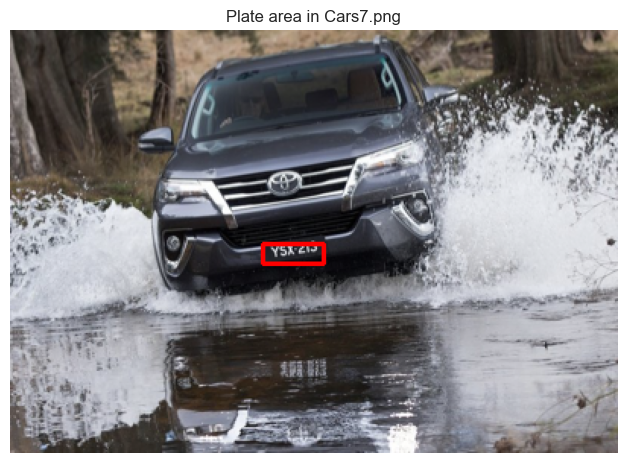

In [42]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Parse the XML annotation file
annotation_path = 'content\\annotations\\Cars7.xml'  # Update with actual XML path
tree = ET.parse(annotation_path)
root = tree.getroot()

# Extract file info and bbox data
filename = root.find('filename').text
xmin = int(root.find('.//xmin').text)
ymin = int(root.find('.//ymin').text)
xmax = int(root.find('.//xmax').text)
ymax = int(root.find('.//ymax').text)

# Read the image
image_path = f'content\\images\\Cars7.png'  # Update with actual image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw the bounding box
boxed_img = image_rgb.copy()
cv2.rectangle(boxed_img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

# Show the image with the bounding box
plt.imshow(boxed_img)
plt.title(f"Plate area in {filename}")
plt.axis('off')
plt.show()


<a id='step20'></a>
### **Easy OCR**

In [ ]:
import os
import easyocr
import cv2
import matplotlib.pyplot as plt


reader = easyocr.Reader(['en'])
plate_dir = 'content/plates' 
sample_count = 10  

plate_images = [f for f in os.listdir(plate_dir) if f.endswith('.png')][:sample_count]

for plate_file in plate_images:
    path = os.path.join(plate_dir, plate_file)
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = reader.readtext(img_rgb)

    if result:
        text = result[0][1]
        conf = result[0][2]
    else:
        text = "[NO TEXT FOUND]"
        conf = 0

    # Display image with result
    plt.imshow(img_rgb)
    plt.title(f"{plate_file} | Text: {text} | Conf: {conf:.2f}")
    plt.axis('off')
    plt.show()


✅ OCR results saved to ocr_results.csv


In [45]:
import pandas as pd
import os
import cv2
import sqlite3
import easyocr

# --- Setup ---
reader = easyocr.Reader(['en'])
db_path = 'database\\dataset.db'  # <-- set this
conn = sqlite3.connect(db_path)

# --- Step 1: Load plates metadata ---
df = pd.read_sql_query("""
    SELECT preprocessed_plate, preprocessed_folder, blur_score, is_blurry
    FROM engineered_plate_features
    WHERE preprocessed_plate IS NOT NULL
""", conn)

ocr_results = []

# --- Step 2: Filter and Run OCR ---
for _, row in df.iterrows():
    if row['is_blurry'] == 1:  # Skip blurry ones
        continue

    plate_path = os.path.join(row['preprocessed_folder'], row['preprocessed_plate'])
    if not os.path.exists(plate_path):
        print(f"⚠️ Missing file: {plate_path}")
        continue

    img = cv2.imread(plate_path)
    if img is None:
        print(f"❌ Failed to load: {plate_path}")
        continue

    result = reader.readtext(img)
    text = result[0][1] if result else "[NO TEXT]"
    conf = result[0][2] if result else 0
    ocr_results.append({
        'preprocessed_plate': row['preprocessed_plate'],
        'ocr_text': text,
        'blur_score': row['blur_score'],
        'conf': conf
    })

# --- Step 3: Save or display results ---
ocr_df = pd.DataFrame(ocr_results)
ocr_df.to_csv("ocr_results.csv", index=False)
print("✅ OCR results saved to ocr_results.csv")


✅ OCR results saved to ocr_results.csv


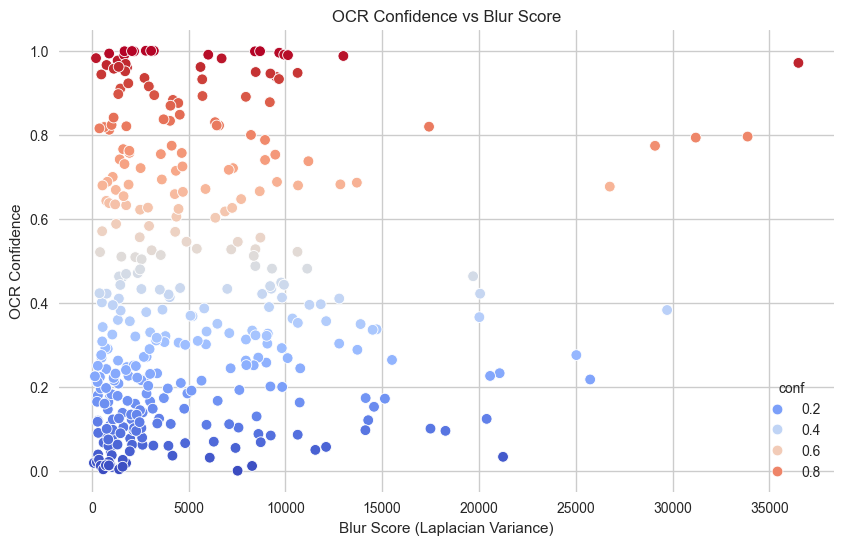

              precision    recall  f1-score   support

           0       0.64      0.57      0.61        47
           1       0.31      0.38      0.34        24

    accuracy                           0.51        71
   macro avg       0.48      0.47      0.47        71
weighted avg       0.53      0.51      0.52        71



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("ocr_results.csv")

# Filter out duplicates if needed
df = df.drop_duplicates(subset='preprocessed_plate')

# Remove empty predictions
df = df[df['ocr_text'] != "[NO TEXT]"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='blur_score', y='conf', hue='conf', palette='coolwarm', s=60)
plt.title("OCR Confidence vs Blur Score")
plt.xlabel("Blur Score (Laplacian Variance)")
plt.ylabel("OCR Confidence")
plt.grid(True)
plt.show()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df['worth_it'] = df['conf'] > 0.5
X = df[['blur_score']]
y = df['worth_it'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))


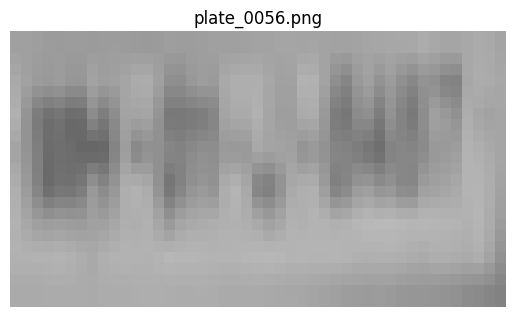

✅ Labeled plate_0056.png



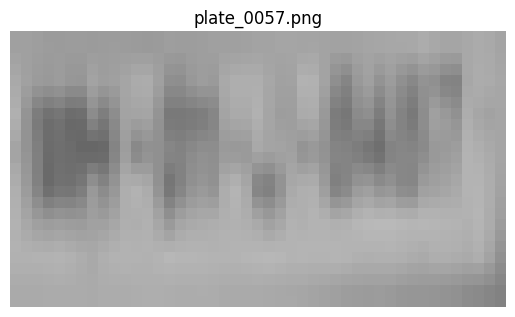

✅ Labeled plate_0057.png



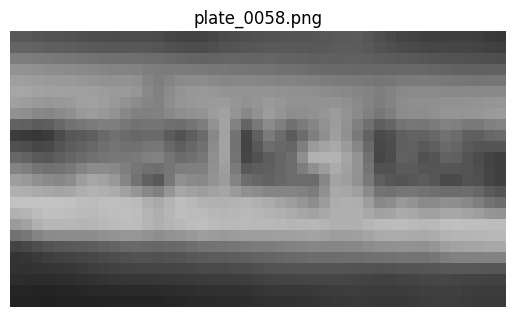

✅ Labeled plate_0058.png



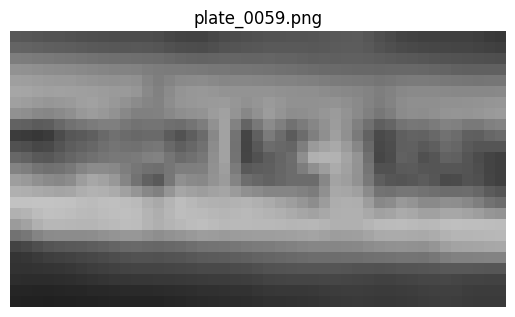

✅ Labeled plate_0059.png



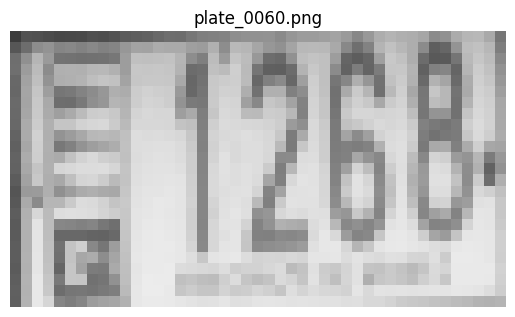

✅ Labeled plate_0060.png



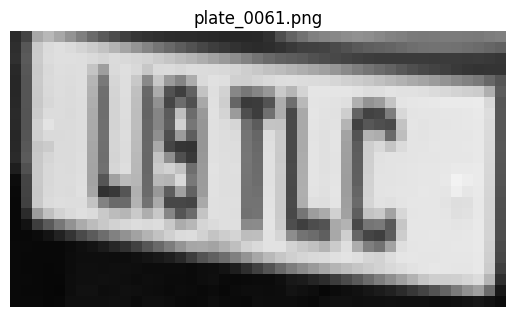

✅ Labeled plate_0061.png



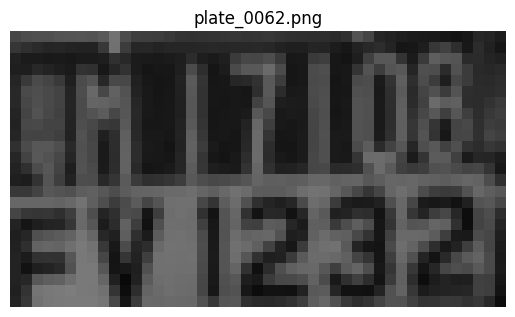

✅ Labeled plate_0062.png



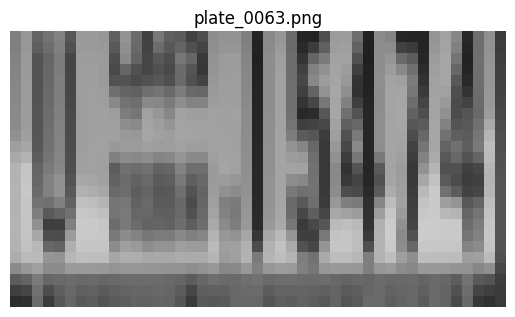

✅ Labeled plate_0063.png



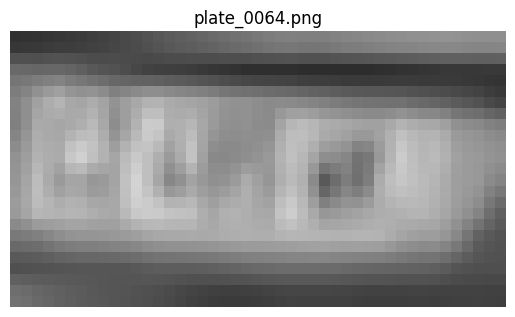

✅ Labeled plate_0064.png



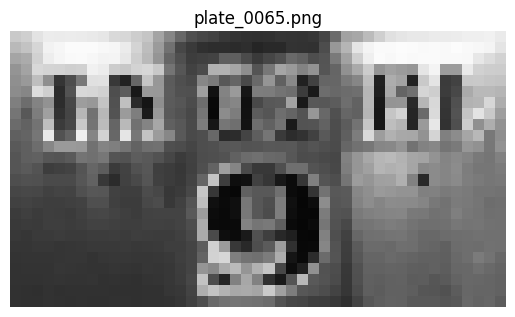

✅ Labeled plate_0065.png



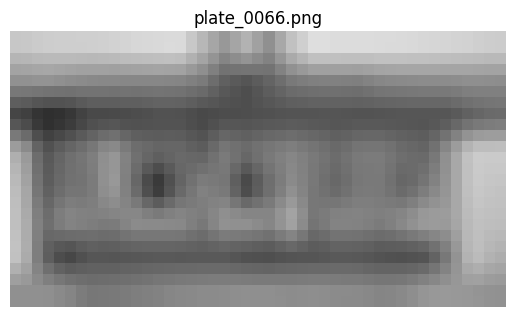

✅ Labeled plate_0066.png



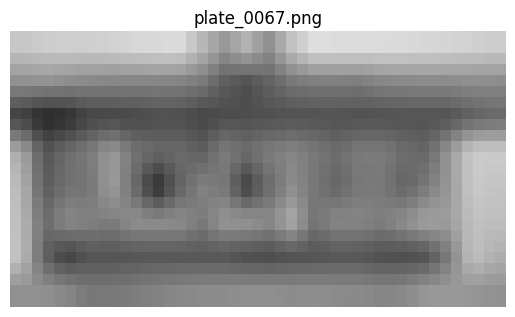

✅ Labeled plate_0067.png



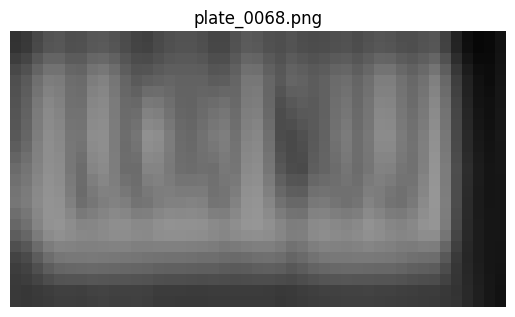

✅ Labeled plate_0068.png



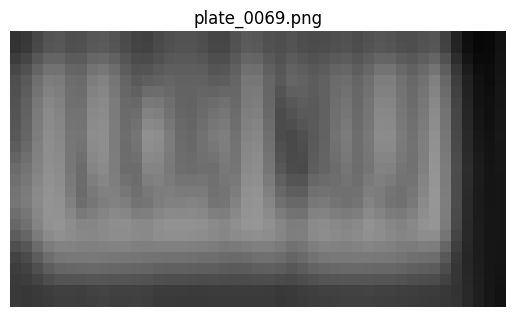

✅ Labeled plate_0069.png



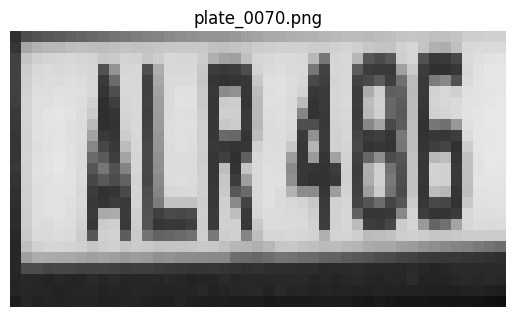

✅ Labeled plate_0070.png



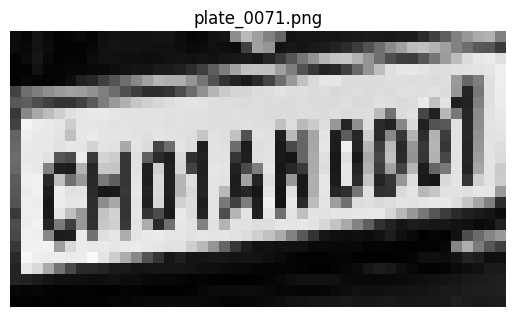

✅ Labeled plate_0071.png



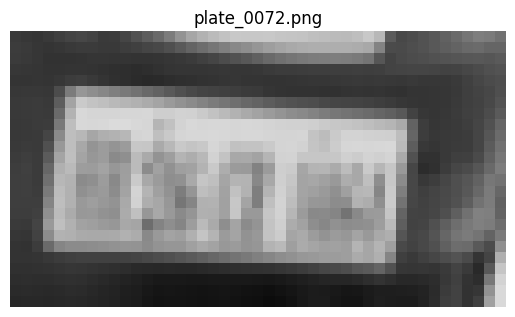

✅ Labeled plate_0072.png



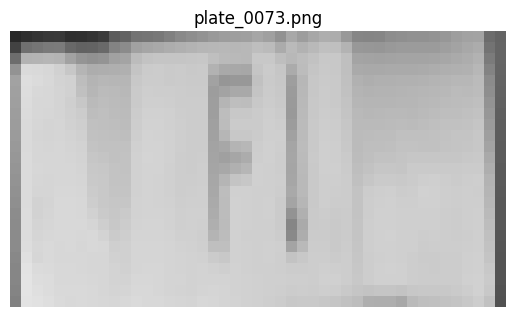

✅ Labeled plate_0073.png



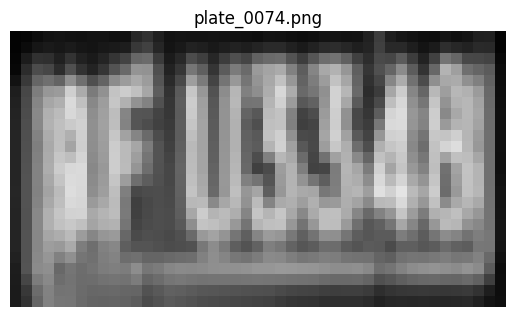

✅ Labeled plate_0074.png



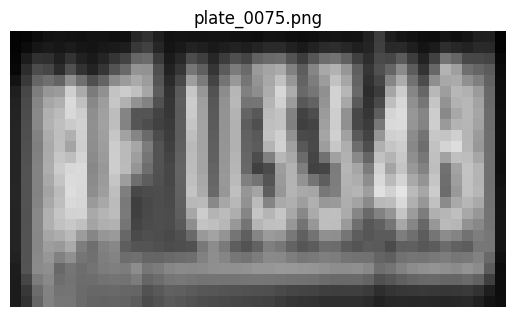

✅ Labeled plate_0075.png



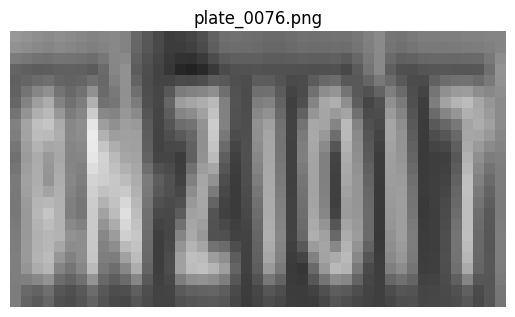

✅ Labeled plate_0076.png



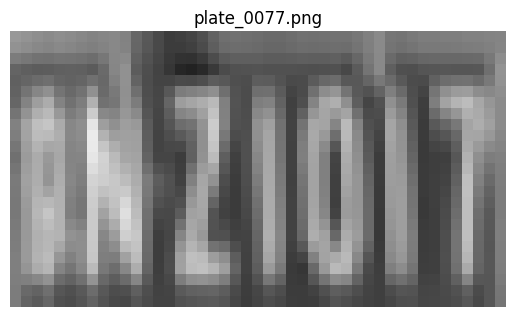

✅ Labeled plate_0077.png



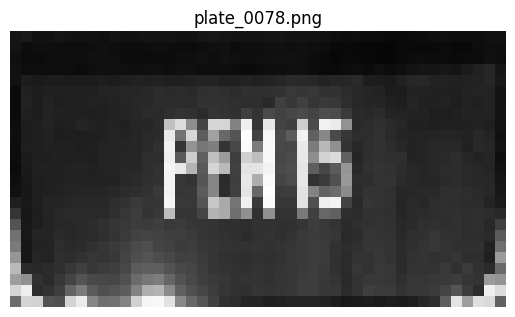

✅ Labeled plate_0078.png



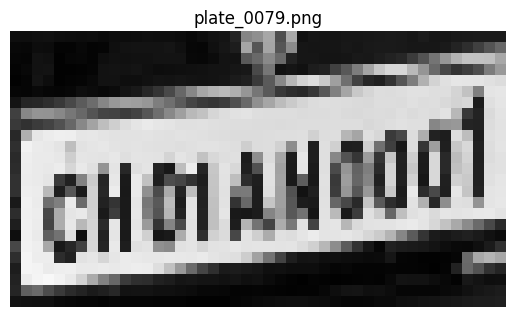

✅ Labeled plate_0079.png



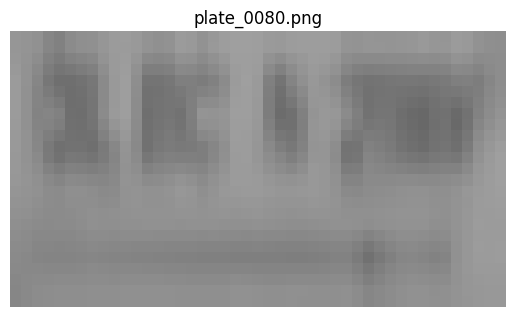

✅ Labeled plate_0080.png



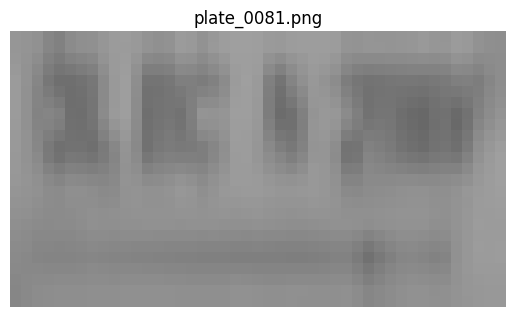

✅ Labeled plate_0081.png



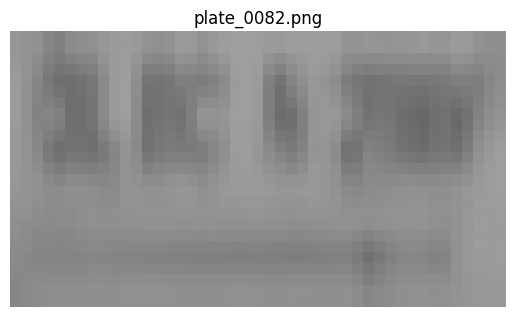

✅ Labeled plate_0082.png



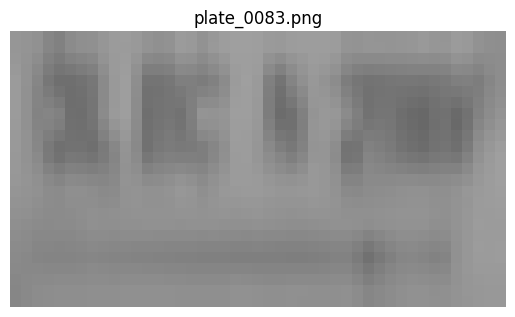

✅ Labeled plate_0083.png



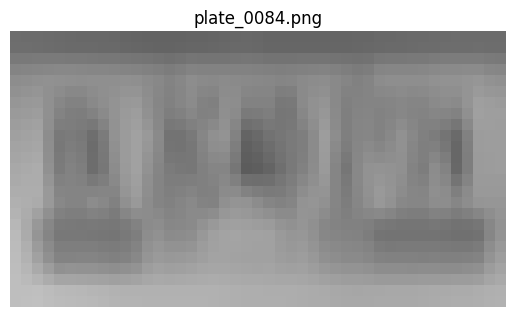

✅ Labeled plate_0084.png



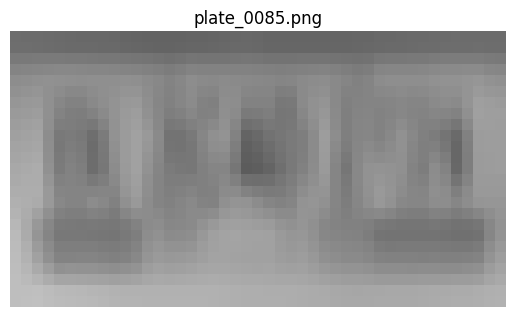

✅ Labeled plate_0085.png



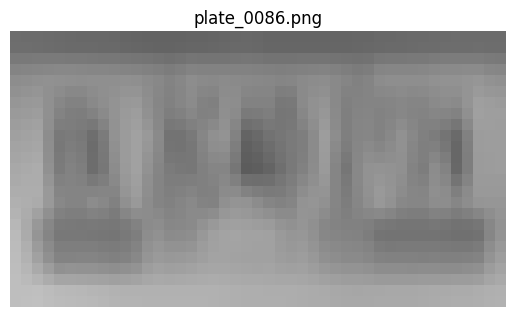

✅ Labeled plate_0086.png



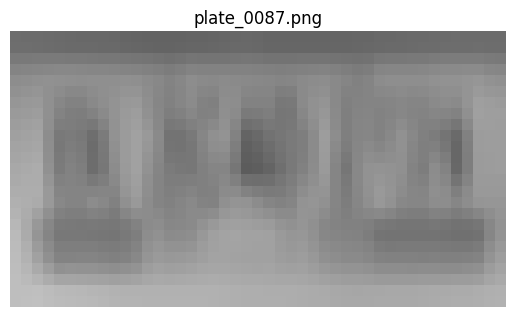

✅ Labeled plate_0087.png



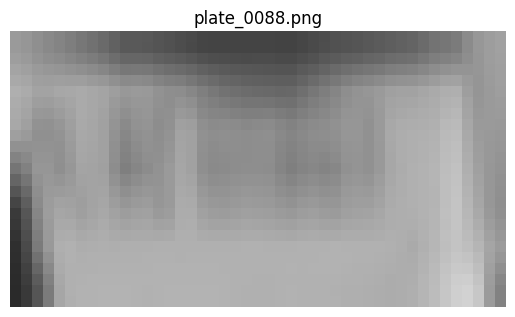

✅ Labeled plate_0088.png



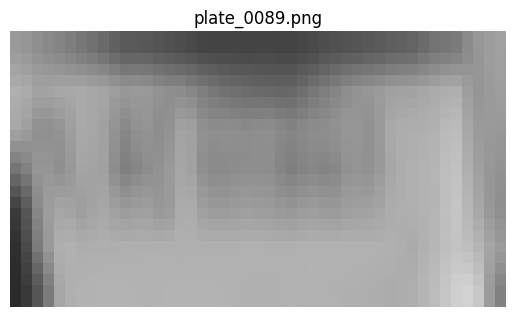

✅ Labeled plate_0089.png



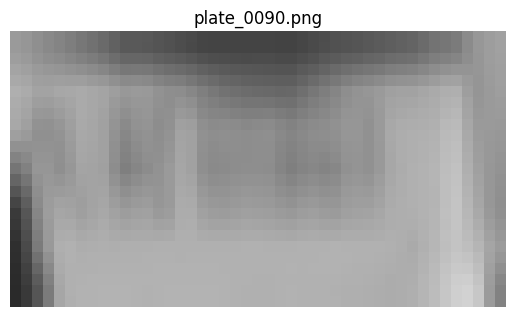

✅ Labeled plate_0090.png



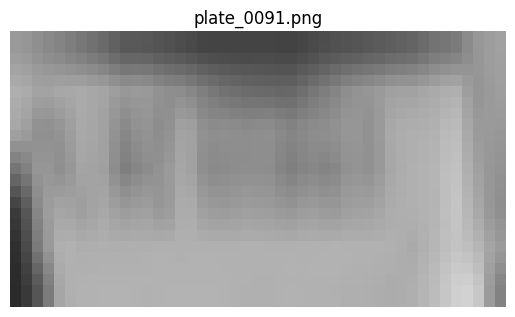

✅ Labeled plate_0091.png



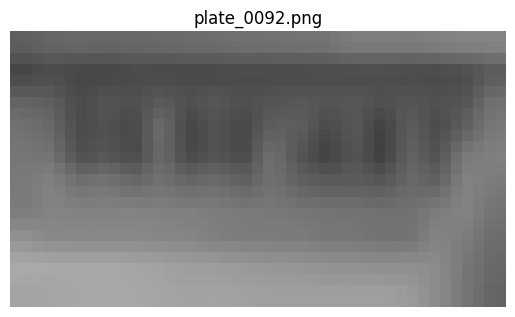

✅ Labeled plate_0092.png



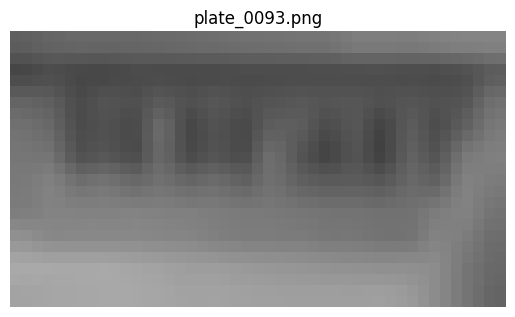

✅ Labeled plate_0093.png



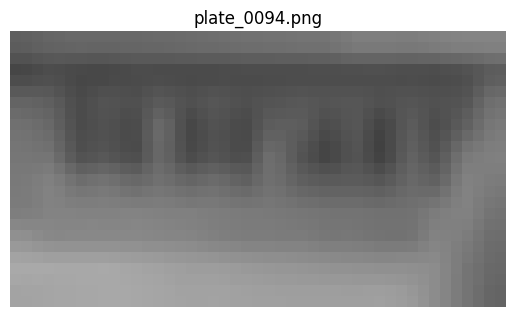

✅ Labeled plate_0094.png



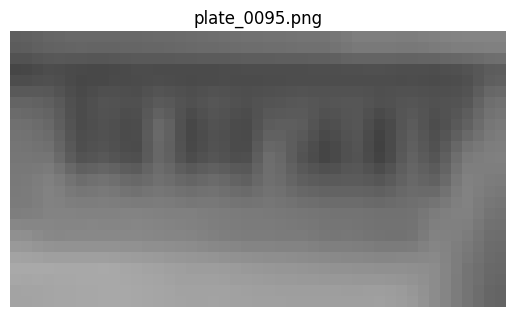

✅ Labeled plate_0095.png



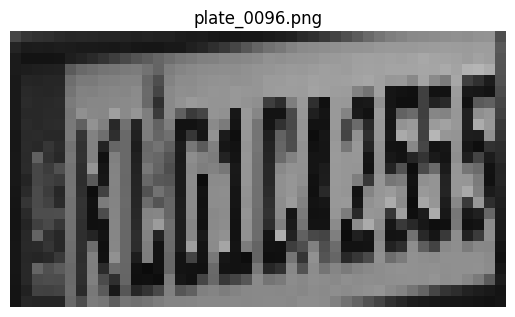

✅ Labeled plate_0096.png



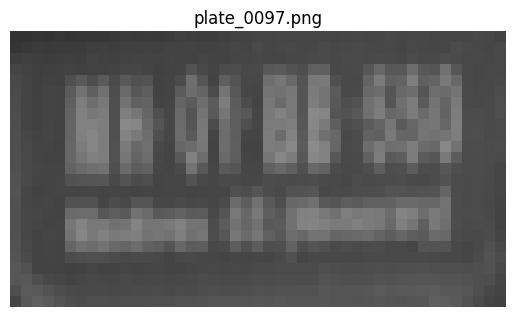

✅ Labeled plate_0097.png



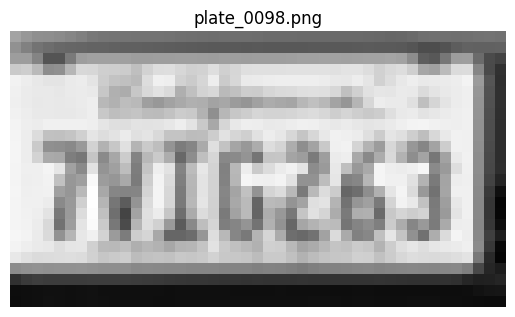

✅ Labeled plate_0098.png



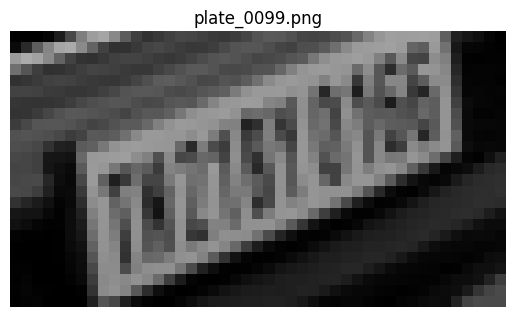

✅ Labeled plate_0099.png



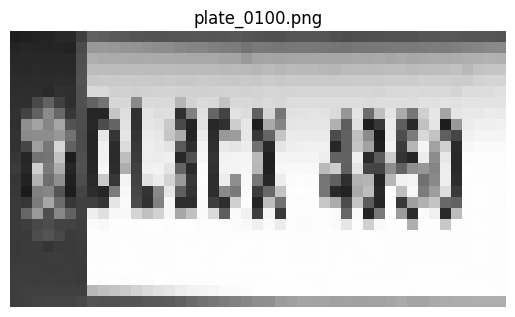

✅ Labeled plate_0100.png



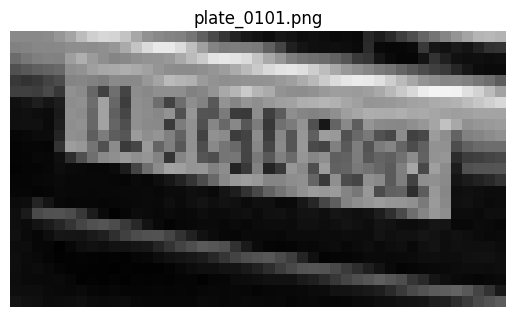

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt


# === Settings ===
plate_dir = os.path.join('content', 'plates')  # Update if needed
save_path = 'ocr_labels.csv'

# === Load or init label file ===
if os.path.exists(save_path):
    df_labels = pd.read_csv(save_path)
else:
    df_labels = pd.DataFrame(columns=['preprocessed_plate', 'ocr_text', 'worth_ocr'])

labeled = set(df_labels['preprocessed_plate'].tolist())

# === List all plate files ===
plate_files = sorted([f for f in os.listdir(plate_dir) if f.endswith('.png')])

for plate_file in plate_files:
    if plate_file in labeled:
        continue  # Skip already labeled

    img_path = os.path.join(plate_dir, plate_file)
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Could not load: {plate_file}")
        continue

    # Show image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(plate_file)
    plt.axis('off')
    plt.show()

    # === Ask for input ===
    ocr_text = input("👉 What is the actual plate text? (or [NO TEXT] if unreadable): ").strip()
    worth_ocr = input("❓ Worth doing OCR on this? (1 = yes, 0 = no): ").strip()

    try:
        worth_ocr = int(worth_ocr)
        assert worth_ocr in [0, 1]
    except:
        print("⚠️ Invalid input for worth_ocr. Skipping.")
        continue

    df_labels.loc[len(df_labels)] = {
        'preprocessed_plate': plate_file,
        'ocr_text': ocr_text,
        'worth_ocr': worth_ocr
    }

    # Save after every entry
    df_labels.to_csv(save_path, index=False)
    print(f"✅ Labeled {plate_file}\n")
    plt.close()

print("🎉 Labeling complete.")







merge datasets

In [1]:
import pandas as pd
import sqlite3

# Load labels and DB features
df_labels = pd.read_csv("ocr_labels.csv")
db_path = 'database\\dataset.db'
conn = sqlite3.connect(db_path)
df_features = pd.read_sql_query("SELECT * FROM engineered_plate_features", conn)
conn.close()

# Merge on filename
df = pd.merge(df_labels, df_features, on="preprocessed_plate", how="inner")

print("✅ Merged data:", df.shape)


✅ Merged data: (69, 14)


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Select features & target
features = ['blur_score', 'bbox_width', 'bbox_height', 'aspect_ratio', 'area_fraction']
X = df[features]
y = df['worth_ocr']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


ocr_df = pd.read_csv("ocr_results.csv")

merged = pd.merge(df_labels, ocr_df, on="preprocessed_plate", how="inner")

# Basic accuracy (exact match)
merged['match'] = merged['ocr_text_x'] == merged['ocr_text_y']
accuracy = merged['match'].mean()
print(f"🔍 Exact OCR match accuracy: {accuracy:.2f}")


              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.92      1.00      0.96        12

    accuracy                           0.94        18
   macro avg       0.96      0.92      0.93        18
weighted avg       0.95      0.94      0.94        18

🔍 Exact OCR match accuracy: 0.32
